### Loading the packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Model

from tensorflow.keras.datasets import fashion_mnist

### Load the dataset

In [ ]:
#
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
# !tar zxvf lfw-deepfunneled.tgz

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
# !tar zxvf lfw.tgz

In [ ]:
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "lfw_attributes.txt"

# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "lfw-deepfunneled.tgz"

# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "lfw.tgz"

In [ ]:
import cv2

In [ ]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [ ]:
import numpy as np
import pandas as pd
import tqdm
import tarfile
import os
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/18983 [00:00<?, ?it/s]

In [ ]:
X = X.astype('float32') / 255.0 - 0.5

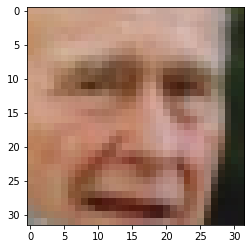

In [ ]:
import matplotlib.pyplot as plt
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
show_image(X[6])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(X, test_size=0.1, random_state=42)
print(x_train.shape)
print(x_test.shape)

(11828, 32, 32, 3)
(1315, 32, 32, 3)


### Implementing the Autoencoder

In [ ]:
latent_dim = 64
img_shape = X.shape[1:]
class Autoencoder(Model):
    def __init__(self,latent_dim):
        super(Autoencoder,self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim,activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(np.prod(img_shape),activation='sigmoid'),
            layers.Reshape(img_shape)                                  
        ])
    def call(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded
autoencoder=Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adamax',loss=losses.MeanSquaredError())


### Model training

In [ ]:
history = autoencoder.fit(x_train,x_train,epochs=20,shuffle=True,
                          validation_data=(x_test,x_test))

Epoch 1/20
370/370 [==============================] - 3s 8ms/step - loss: 0.0448 - val_loss: 0.0330
Epoch 2/20
370/370 [==============================] - 3s 8ms/step - loss: 0.0331 - val_loss: 0.0318
Epoch 3/20
370/370 [==============================] - 3s 8ms/step - loss: 0.0322 - val_loss: 0.0311
Epoch 4/20
370/370 [==============================] - 3s 8ms/step - loss: 0.0315 - val_loss: 0.0306
Epoch 5/20
370/370 [==============================] - 3s 8ms/step - loss: 0.0310 - val_loss: 0.0301
Epoch 6/20
370/370 [==============================] - 3s 8ms/step - loss: 0.0306 - val_loss: 0.0297
Epoch 7/20
370/370 [==============================] - 3s 8ms/step - loss: 0.0301 - val_loss: 0.0294
Epoch 8/20
370/370 [==============================] - 3s 8ms/step - loss: 0.0297 - val_loss: 0.0290
Epoch 9/20
370/370 [==============================] - 3s 8ms/step - loss: 0.0294 - val_loss: 0.0286
Epoch 10/20
370/370 [==============================] - 3s 8ms/step - loss: 0.0291 - val_loss: 0.0283

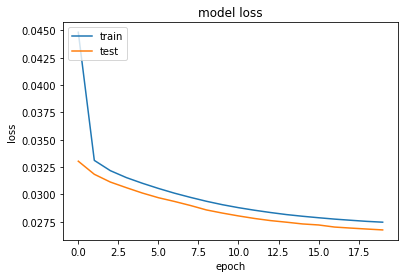

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

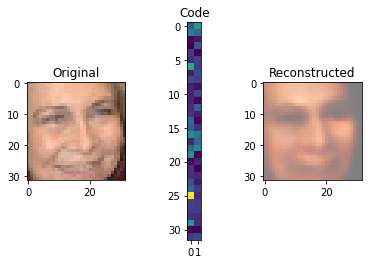

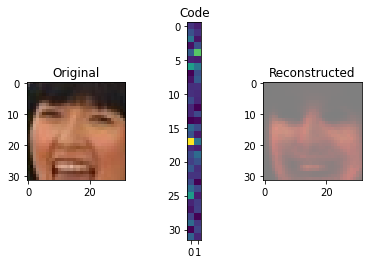

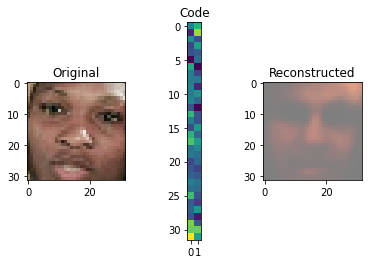

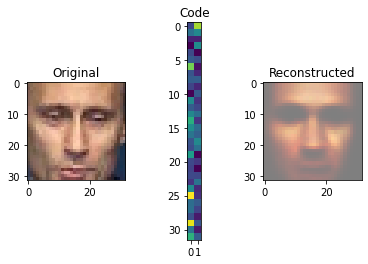

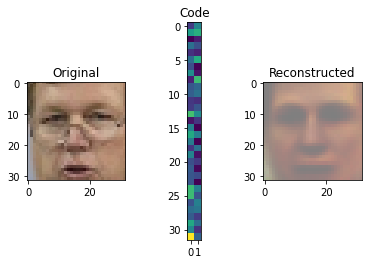

In [ ]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

for i in range(5):
    img = x_test[i]
    visualize(img,autoencoder.encoder,autoencoder.decoder)